In [1]:
%load_ext autoreload
%autoreload 2

In [206]:
import bayes3d as b3d
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
import numpy as np
import genjax
import trimesh
import matplotlib.pyplot as plt
from bayes3d.genjax.genjax_distributions import *

# console = genjax.pretty(show_locals=False)

In [207]:
from jax.scipy.spatial.transform import Rotation
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
normal_pdf       = jax.scipy.stats.norm.pdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf

inv       = jnp.linalg.inv
logaddexp = jnp.logaddexp
logsumexp = jax.scipy.special.logsumexp

key = jax.random.PRNGKey(0)

In [208]:
from xsight.utils import keysplit
from xsight.plotting import *

## Grid

In [209]:
def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

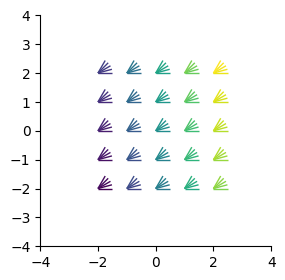

In [210]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 2, ax=ax)
plot_poses(vs, sc, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Renderer and meshes

In [211]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)


# Add invisible atomic table
mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-9
meshes.append(mesh)


In [212]:
#| Set up the renderer and add the scene mesh
def make_render_function(meshes, w=100, h=100, fx=30, fy=30, far=20, near=0.01):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx=fx, fy=fy,
        cx=w/2 - 0.5, cy=h/2 - 0.5,
        near=near, far=far
    )
    
    b3d.setup_renderer(intrinsics)
    for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

    def render(cam:"Camera Pose", ps:"Object Poses", inds:"Object indices"): 
        return b3d.RENDERER.render(inv(cam) @ ps , inds)[...,:3]

    return render

In [213]:
_far   = 5.0
_shape = (200,200)
_f     = 300

_intr   = dict(w=_shape[1], h=_shape[0], fx=_f, fy=_f, near=0.0001, far=_far)
render   = make_render_function(meshes, **_intr)

help(render)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)
Help on function render in module __main__:

render(cam: 'Camera Pose', ps: 'Object Poses', inds: 'Object indices')



In [214]:
def prep_im(Y, far=_far, eps=1e-6):
    im = np.where(Y[:,:,2]>= _far - eps, jnp.inf, Y[:,:,2])
    return im

In [215]:
def make_table_scene_model():

    @genjax.gen
    def model(nums, 
              possible_object_indices, 
              pose_bounds, 
              contact_bounds, 
              all_box_dims):
        
        num_objects = len(nums) # this is a hack, otherwise genajx is complaining

        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(3):

            index  = uniform_discrete(possible_object_indices)    @ f"id_{i}"
            pose   = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"
            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj  = uniform_discrete(jnp.arange(-1, num_objects - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face  = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices        = jnp.concatenate([indices, jnp.array([index])])
            root_poses     = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents        = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents  = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child    = jnp.concatenate([faces_child, jnp.array([child_face])])
        

        scene = (root_poses, all_box_dims[indices], parents, contact_params, faces_parents, faces_child)
        poses = b.scene_graph.poses_from_scene_graph(*scene)

        camera_pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"camera_pose"

        return camera_pose, poses, indices

    return model

In [216]:
model = make_table_scene_model()

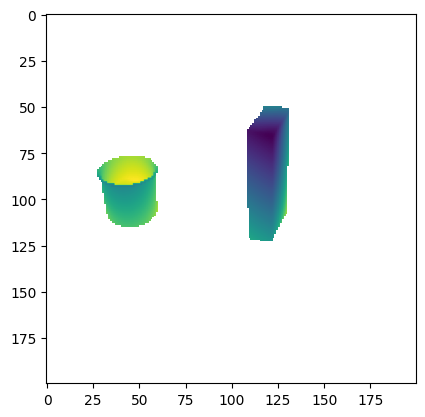

In [249]:
key = keysplit(key)

cam_x = jnp.array([0.0, -.5, -.75])
cam   = b3d.transform_from_pos_target_up(cam_x, jnp.zeros(3), jnp.array([0.0,-1.0,0.0]))

table = jnp.eye(4)

args = (
    jnp.arange(3),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b3d.RENDERER.model_box_dims
)

ch = genjax.choice_map({
    "parent_0": -1,
    "parent_1":  0,
    "parent_2":  0,
    "camera_pose": cam,
    "root_pose_0": table,
    "id_0": jnp.int32(21), # Atomic Table
    "id_1": jnp.int32(13), # Mug
    "id_2": jnp.int32(2),  # Box
    "face_parent_1": 1,  # That's the top face of the table
    "face_parent_2": 1,  # ...
    "face_child_1": 3,   # That's a bottom face of the mug
    "face_child_2": 3,
})


w, tr = model.importance(key, ch , args)
cam, ps, inds = tr.retval
X = render(cam, ps, inds)


# =====================
plt.imshow(prep_im(X))